In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from lib import jsoncorpus, datastuff, analysis
import gensim
import traceback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.svm
import sklearn.decomposition
import sklearn.neighbors
from lib.scikitComponents import *
import itertools
import collections
from lib.scikitComponents import pipelines

## Data preprocessing

In [4]:
# Load in the previously created corpus and dictionary of scraped sites
#dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl')
dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl', stemmed=True, prefix="stemmed_")

Done.


In [8]:
def merge_corpus(a, b):
    a = dict(a)
    b = dict(b)
    for k in b:
        old = a.get(k, 0)
        a[k] = old + b[k]
    return [(k, a[k]) for k in a]


merged_corpus = [merge_corpus(a, b) for a, b in zip(corpus, meta_corpus)]


In [9]:
# Set up array of input data
X = zip(list(corpus), list(meta_corpus), merged_corpus)
# Link topics to URLs
meta = list(zip(dmoz_data['urls'], dmoz_data['dmoz_categories']))
# Encode class labels
classes, top_categories, dmoz_encoder = datastuff.encode_dmoz_categories(dmoz_data['dmoz_categories'], merged_corpus, level=0, minwords = 0)

print max(classes)
#X = [X[i] for i in nonempties]

verbosity = 0

14


## Get the scores of different combinations of classifiers

In [14]:
# TFIDF on body and metadata, LinearSVC
clf5 = pipelines.make_classifier(dictionary, feature='tfidf', corp_type='both', classifier = 'svc')
scores = sklearn.cross_validation.cross_val_score(clf5, X, classes, cv=5, verbose = verbosity)
analysis.print_score_accuracy(scores)

Accuracy: 0.564 (+/- 0.07)


### Find good parameter for C

In [15]:
# clf = pipelines.make_classifier(dictionary, feature='tfidf', corp_type='both', classifier = 'svc_gridsearch')
# clf.fit(X, classes)
# print clf.steps[2][1].best_estimator_
# clf.steps[2][1].grid_scores_

In [16]:
# clf = pipelines.make_classifier(dictionary, feature='tfidf', corp_type='both', classifier = 'svc_gridsearch')
# clf.fit(X, classes)
# print clf.steps[2][1].best_estimator_
# clf.steps[2][1].grid_scores_

## Do some analysis on a single test/train split

### Find the score for each category. 

Note that if the classifier assigned *random* categories, the score would be $\frac{1}{\textrm{num categories}}$. Instead, it is actually quite high in some cases, indicating a moderate amount of success (given how naive this is!)

In [109]:
X_train, X_test, y_train, y_test, ind_train, ind_test = datastuff.tt_split(X, classes, test_size = 0.2)
clf = pipelines.make_classifier(dictionary, feature='tfidf', corp_type='both', classifier = 'svc')
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print sklearn.metrics.classification_report(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)


             precision    recall  f1-score   support

       arts       0.51      0.60      0.55        30
   business       0.78      0.62      0.69        52
  computers       0.79      0.83      0.81        59
      games       0.64      0.86      0.73        21
     health       0.61      0.76      0.68        29
       home       0.74      0.77      0.75        26
kids and teens       0.62      0.67      0.65        15
       news       0.72      0.69      0.71        42
 recreation       0.79      0.57      0.67        40
  reference       0.54      0.47      0.50        45
   regional       0.11      0.67      0.19         3
    science       0.64      0.63      0.64        54
   shopping       0.67      0.74      0.70        35
    society       0.65      0.29      0.40        45
     sports       0.80      0.90      0.85       104

avg / total       0.70      0.69      0.68       600



### Plot a confusion matrix

array([ 0.55384615,  0.68817204,  0.80991736,  0.73469388,  0.67692308,
        0.75471698,  0.64516129,  0.70731707,  0.66666667,  0.5       ,
        0.19047619,  0.63551402,  0.7027027 ,  0.4       ,  0.85067873])

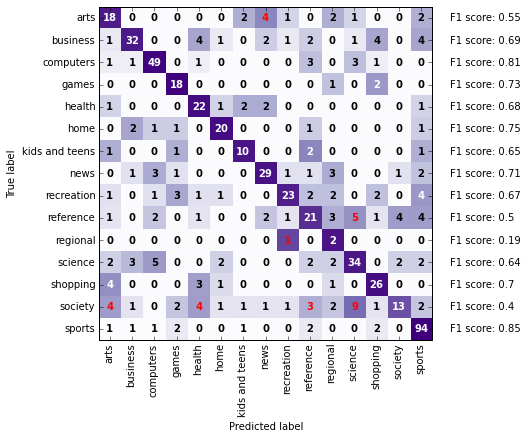

In [119]:
cm = sklearn.metrics.confusion_matrix(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)
analysis.plot_confusion_matrix(cm, labels=dmoz_encoder.classes_, title=None, cmap=plt.cm.Purples, scores = sklearn.metrics.f1_score(y_test, predicted, average=None))
plt.savefig('confusion_main.pdf', bbox_inches='tight')
plt.show()

### Confusion matrix of the second guesses, first guess was wrong

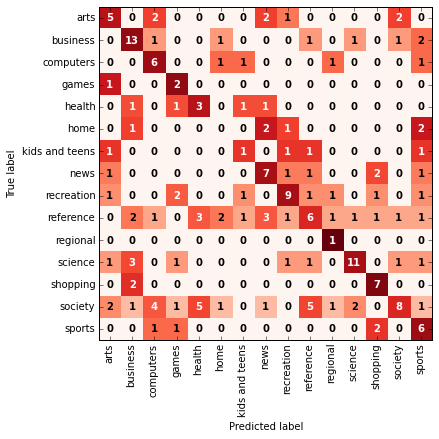

In [120]:
guesses = dmoz_encoder.inverse_transform(np.fliplr(np.argsort(clf.decision_function(X_test))))
real_labels = dmoz_encoder.inverse_transform(y_test)[y_test != predicted]
pred_labels = np.array([g[1] for g in guesses])[y_test != predicted]
cm = sklearn.metrics.confusion_matrix(real_labels, pred_labels, dmoz_encoder.classes_)
analysis.plot_confusion_matrix(cm, labels=dmoz_encoder.classes_, title=None, showwarnings=False, cmap=plt.cm.Reds)
plt.savefig('confusion_first-was-wrong.pdf', bbox_inches='tight')
plt.show()

### Confusion matrix of the second guesses, first guess was correct

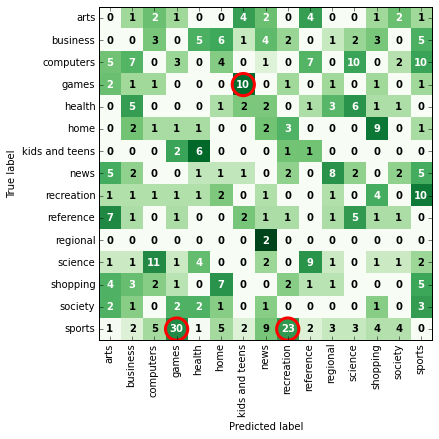

In [124]:
guesses = dmoz_encoder.inverse_transform(np.fliplr(np.argsort(clf.decision_function(X_test))))
real_labels = dmoz_encoder.inverse_transform(y_test)[y_test == predicted]
pred_labels = np.array([g[1] for g in guesses])[y_test == predicted]
cm = sklearn.metrics.confusion_matrix(real_labels, pred_labels, dmoz_encoder.classes_)
analysis.plot_confusion_matrix(cm, labels=dmoz_encoder.classes_, title=None, showwarnings=False, cmap=plt.cm.Greens)

def draw_circle(pos, r=0.5, color='r', fill=False, linewidth=3):
    c = plt.Circle(pos, r, color=color, fill=fill, linewidth=linewidth)
    fig = plt.gcf()
    fig.gca().add_artist(c)
    
draw_circle((6, 3))
draw_circle((3, 14))
draw_circle((8, 14))

plt.savefig('confusion_first-was-good.pdf', bbox_inches='tight')
#plt.scatter([1],[1])
#plt.xlim((-0.5, 14.5))
#plt.ylim((-0.5, 14.5))
plt.show()

In [143]:
inds = [g[1] for g in guesses] == dmoz_encoder.inverse_transform(y_test)
sum(inds)

85

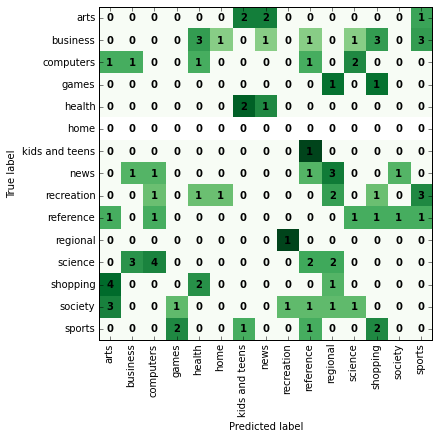

In [144]:
inds = [g[1] for g in guesses] == dmoz_encoder.inverse_transform(y_test)
guesses = dmoz_encoder.inverse_transform(np.fliplr(np.argsort(clf.decision_function(X_test))))
real_labels = dmoz_encoder.inverse_transform(y_test)[inds]
pred_labels = np.array([g[0] for g in guesses])[inds]
cm = sklearn.metrics.confusion_matrix(real_labels, pred_labels, dmoz_encoder.classes_)
analysis.plot_confusion_matrix(cm, labels=dmoz_encoder.classes_, title=None, showwarnings=False, cmap=plt.cm.Greens)

def draw_circle(pos, r=0.5, color='r', fill=False, linewidth=3):
    c = plt.Circle(pos, r, color=color, fill=fill, linewidth=linewidth)
    fig = plt.gcf()
    fig.gca().add_artist(c)
    


#plt.savefig('confusion_first-was-good.pdf', bbox_inches='tight')
#plt.scatter([1],[1])
#plt.xlim((-0.5, 14.5))
#plt.ylim((-0.5, 14.5))
plt.show()

In [340]:
[i for i, m in enumerate(meta) if m[0] == "http://www.evertrust.org/"]
mmm = merged_corpus[1275]

In [324]:
inspector = analysis.ExampleInspector(dictionary, clf, X_test, y_test, predicted, meta, ind_test, dmoz_encoder)
inspector.get_confusion(predicted_as = 8, only_failures=True)
print
print
#inspector.get_confusion(13, 11, 1)

incorrectly classified  samples predicted as 'none'

http://www.kiiking.ee/ sports, extreme sports
Predicted as: none, sports, society
None words: melayu, xs, caught, bookmark, christma, sheet, sheer, sheep, size

http://www.mynewsreader.com/robots.txt news, personalized news
Predicted as: none, recreation, news
None words: melayu, 1220, drove, ring, xs, expir, undergradu, rink, wedg

http://www.framtiden-er-din.com/ society, future
Predicted as: none, sports, recreation
None words: melayu, xt, traction, eachoth, breed, caught, bookmark, christma, sheet

http://www.racquetballstrategy.blogspot.co.uk/ sports, racquetball
Predicted as: none, sports, recreation
None words: melayu, 620, xs, expir, undergradu, rink, wedg, rins, zac

http://www.paulawalla.com/ shopping, ethnic and regional
Predicted as: none, sports, business
None words: melayu, zac, xt, angular, drove, ring, xs, expir, undergradu

http://www.asr-gooyesh.com/fa/ computers, speech technology
Predicted as: none, sports, comput

### Look at the SVM coefficients for words

In [349]:
words = []
for c in range(14):
    weights = clf.steps[2][1].coef_[c]
    inds = np.argsort(weights)[::-1]
    best = [dictionary[i] for i in inds][:9]
    words.append(best)
    print "{{{}}}: {}".format(dmoz_encoder.inverse_transform(c), ", ".join(best))
#np.array(words)

{arts}: art, artist, design, film, architectur, award, font, tattoo, costum
{business}: busi, compani, drill, product, manag, manufactur, corpor, financi, market
{computers}: comput, file, softwar, usenet, window, system, robot, bb, supercomput
{games}: game, dice, rpg, wargam, puzzl, miniatur, warhamm, play, parti
{health}: health, pharmaci, diseas, addict, age, drug, care, clinic, medic
{home}: garden, diy, toy, plant, recip, apart, kitchen, decor, clean
{kids and teens}: kid, parent, homeschool, fun, children, teacher, math, teen, school
{news}: ferguson, news, newspap, weather, radio, obama, polit, netanyahu, iran
{none}: cri, barbara, load, foundat, intermediari, -base, pointless, earnest, novella
{recreation}: cave, lock, climb, bird, travel, naturist, hike, pet, rate
{reference}: librari, dictionari, museum, thesauru, word, knot, answer, archiv, bibliographi
{regional}: popul, countri, 01, geograph, stat, citi, nat, geo, trip
{science}: scienc, astronomi, physic, scientif, firew

### How good are the top N guesses?

In [23]:
clfs = [
    pipelines.make_classifier(dictionary, feature='tfidf', classifier = 'svc'),
    pipelines.make_classifier(dictionary, feature='tfidf', classifier = 'svc', corp_type='body'),
    pipelines.make_classifier(dictionary, feature='tfidf', classifier = 'svc', corp_type='meta'),
    pipelines.make_classifier(dictionary, feature='tfidf', classifier = 'sgd'),
    pipelines.make_classifier(dictionary, feature='count', classifier = 'nb'),
    pipelines.make_classifier(dictionary, feature='lda', classifier = 'trees'),
]

In [63]:
results = []
i = 0
for ind_train, ind_test in iter(sklearn.cross_validation.StratifiedKFold(classes, n_folds=5)):
    X_train, y_train  = np.array(X)[ind_train], np.array(classes)[ind_train]
    X_test, y_test  = np.array(X)[ind_test], np.array(classes)[ind_test]
    accuracies = []
    for legend, clf in zip(legends, clfs):
        print "{}: Testing \"{}\" classifier".format(i, legend)
        clf.fit(X_train, y_train)
        accuracies.append(analysis.accuracy_of_top_n_guesses(clf, X_test, y_test))
    results.append(accuracies)
    i += 1

0: Testing "lda(both) - D.Trees" classifier
0: Testing "count(both) - N.Bayes" classifier
0: Testing "tfidf(meta) - SVM" classifier
0: Testing "tfidf(body) - SVM" classifier
0: Testing "tfidf(both) - SVM" classifier
0: Testing "tfidf(both) - SGD" classifier
1: Testing "lda(both) - D.Trees" classifier
1: Testing "count(both) - N.Bayes" classifier
1: Testing "tfidf(meta) - SVM" classifier
1: Testing "tfidf(body) - SVM" classifier
1: Testing "tfidf(both) - SVM" classifier
1: Testing "tfidf(both) - SGD" classifier
2: Testing "lda(both) - D.Trees" classifier
2: Testing "count(both) - N.Bayes" classifier
2: Testing "tfidf(meta) - SVM" classifier
2: Testing "tfidf(body) - SVM" classifier
2: Testing "tfidf(both) - SVM" classifier
2: Testing "tfidf(both) - SGD" classifier
3: Testing "lda(both) - D.Trees" classifier
3: Testing "count(both) - N.Bayes" classifier
3: Testing "tfidf(meta) - SVM" classifier
3: Testing "tfidf(body) - SVM" classifier
3: Testing "tfidf(both) - SVM" classifier
3: Testing

In [64]:
r = np.array(results)

In [77]:
rm[rm.mean(axis=1).argsort()]

array([[ 0.38199575,  0.54836855,  0.65267808,  0.72899833,  0.79244066,
         0.84411278,  0.8741479 ,  0.90711228,  0.93124311,  0.95082182,
         0.96329859,  0.97830322,  0.9866397 ,  0.99290219],
       [ 0.45145444,  0.60026889,  0.680338  ,  0.73796846,  0.78550811,
         0.82933386,  0.86933942,  0.89981163,  0.92400198,  0.94490644,
         0.95781788,  0.97493996,  0.9912251 ,  0.99957806],
       [ 0.49970365,  0.65593997,  0.74226255,  0.79988531,  0.84825   ,
         0.87993746,  0.90916476,  0.9303978 ,  0.94624963,  0.96001101,
         0.97457971,  0.98041703,  0.98666581,  0.99792086],
       [ 0.54150721,  0.69035546,  0.76586891,  0.80591346,  0.84392   ,
         0.87645106,  0.89772952,  0.91899754,  0.94781237,  0.96279006,
         0.97699537,  0.98786264,  0.99706568,  0.99958592],
       [ 0.53575566,  0.6965963 ,  0.77078792,  0.81710329,  0.85599368,
         0.88394914,  0.90733294,  0.92860885,  0.94782231,  0.95950182,
         0.97037246,  0.98

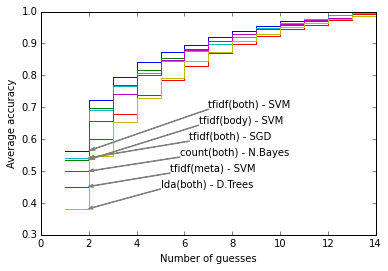

In [89]:
rm = np.mean(r, axis=0)
for i in range(6):
    plt.step(range(1, r.shape[2]+1), rm[i], where='post')
i = 0
sortinds = rm.mean(axis=1).argsort()
for a, c in zip(rm[sortinds], np.array(clfs)[sortinds]):
    tx = 5+i*0.4
    ty = 0.45 +i*0.05
    text = c.name
    props = dict(color='gray', shrink=0.0, frac=0.05, width=0.5, headwidth=3)
    plt.annotate(text, xy = (2, a[0]), xytext=(tx, ty), arrowprops = props)
    i+=1
plt.xlim((0, 14))
plt.ylabel('Average accuracy')
plt.xlabel('Number of guesses')
plt.savefig('classifier-n-guesses-avg.pdf'.format(i+1), bbox_inches='tight')

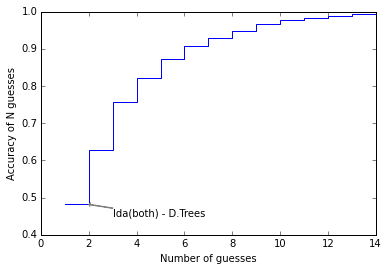

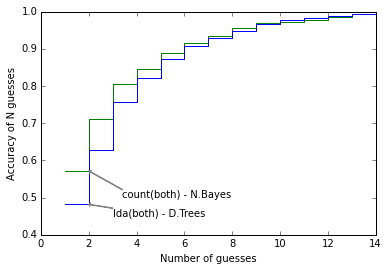

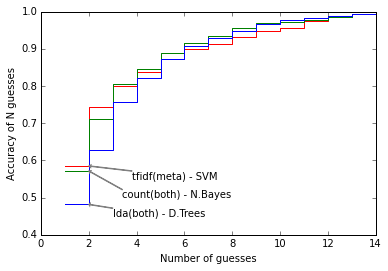

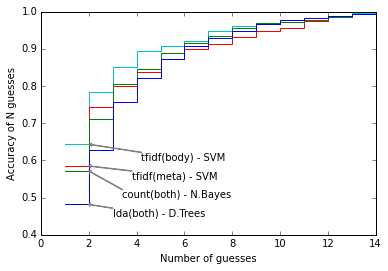

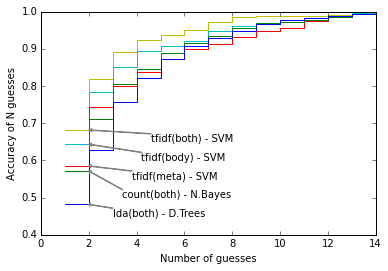

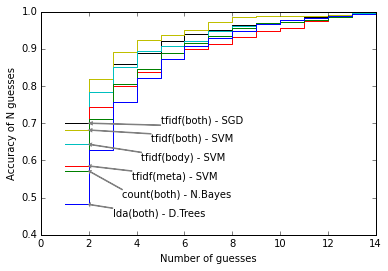

In [107]:
colors = ['b','g','r','c','y','k', 'lightsalmon', 'orange', 'orchid']
    
for i in range(len(clfs)):
    f = plt.figure()
    lines = [
        plt.step(range(1, len(accuracies[j])+1),accuracies[j], c = colors[j], where='post')[0]
        for j in range(i, -1, -1)
    ]
    plt.ylim((0.4, 1))
    plt.xlim(0, len(accuracies[0]))
    plt.ylabel('Accuracy of N guesses')
    plt.xlabel('Number of guesses')
    for a, c, i in zip(accuracies, clfs, range(len(accuracies[0])))[:i+1]:
        tx = 3+i*0.4
        ty = 0.45 +i*0.05
        text = c.name
        props = dict(color='gray', shrink=0.0, frac=0.05, width=0.5, headwidth=3)
        plt.annotate(text, xy = (2, a[0]), xytext=(tx, ty), arrowprops = props)
        
    plt.savefig('classifier-n-guesses_{}.pdf'.format(i+1), bbox_inches='tight')
    plt.show()


### Get Bag-Of-Words examples

In [51]:
d, c, m, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl', stemmed=True, prefix="stemmed_")
#d, c, m, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl')
[i for i, q in enumerate(meta) if 'skinet' in q[0]]

print "BODY"
arr = sorted([(d[w], int(count)) for w, count in c[185]])
print ", ".join("{}~({})".format(w, c) for w, c in arr)

print "META"
arr = sorted([(d[w], int(count)) for w, count in m[185]])
print ", ".join("{}~({})".format(w, c) for w, c in arr)


Done.
BODY
101~(1), 1949~(1), 1968~(1), 2015~(2), 31~(1), 66~(2), abus~(2), acl~(1), activ~(1), advic~(1), aid~(1), airbag~(1), aliv~(1), audienc~(1), avalanch~(2), bar~(1), bay~(1), bc~(1), big~(1), blow~(1), brave~(1), break~(1), british~(1), bum~(1), champ~(1), code~(1), columbia~(1), compani~(1), copyright~(1), crack~(1), creat~(1), cruz~(1), deepest~(1), dream~(1), elk~(1), enjoy~(1), entertain~(1), excit~(1), exot~(1), explor~(1), famili~(1), film~(2), financi~(2), fli~(1), friend~(1), gear~(2), goal~(1), grand~(1), great~(1), group~(1), hotel~(1), idea~(2), inspir~(1), interest~(1), jump~(1), lab~(1), largest~(1), latest~(1), lifetim~(1), locat~(2), luxuri~(1), magazin~(5), massiv~(1), media~(1), meet~(1), midwest~(1), miller~(4), mountain~(2), network~(1), nevada~(1), organ~(1), perform~(1), polici~(1), powder~(2), privaci~(1), publish~(1), race~(1), record~(1), recreat~(1), region~(1), reno~(1), review~(1), safer~(1), scene~(1), servic~(1), set~(1), shot~(1), ski~(13), skier~(

### See some examples of misclassified websites

In [346]:
import urllib2

fullclf = pipelines.make_classifier(dictionary, feature='tfidf', corp_type='both', classifier = 'svc', class_weight='auto')
fullclf.fit(X, classes)

Pipeline(steps=[('selection', ItemPicker(index=2)), ('feature', Pipeline(steps=[('tfidf', TFIDFModel(id2word=None)), ('matrix', TopicMatrixBuilder(keep_all=True, num_topics=13021, topic_min_members=0))])), ('classifier', LinearSVC(C=0.04, class_weight='auto', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [347]:

response = urllib2.urlopen('http://bacon.com')
html = response.read()

processed = jsoncorpus.process_html(html)
words = processed[0] + list(itertools.chain.from_iterable(processed[1].values()))
stopped = (word for word in words if word not in datastuff.stoplist)
stemmed = list(jsoncorpus.stem_words(stopped))
doc = dictionary.doc2bow(stemmed)

d = [doc, doc, doc]
probas = fullclf.predict_proba([d]) if hasattr(fullclf,'predict_proba') else fullclf.decision_function([d])
preds = np.fliplr(np.argsort(probas))
print dmoz_encoder.inverse_transform(preds)[0][:3]
#print fullclf.predict_proba([d])
print np.sort(probas[0])[::-1][:3]

weights = fullclf.steps[2][1].coef_
transformed = Pipeline(fullclf.steps[:2]).transform([d])
trf = transformed[0] * weights[preds[0][1]]
inds = np.argsort(trf)[::-1]
best = [dictionary[i] for i in inds][:9]
print ", ".join(best)
trf = transformed[0] * weights[preds[0][0]]
inds = np.argsort(trf)[::-1]
best = [dictionary[i] for i in inds][:9]
print ", ".join(best)

[u'none' u'sports' u'recreation']
[-0.87555712 -0.9031664  -0.91405819]
2015, mark, lindsey, panorama, drove, ring, xs, expir, undergradu
melayu, 1220, drove, ring, xs, expir, undergradu, rink, wedg


In [348]:
joblib.dump(fullclf, 'classifier2.pkl') 

['classifier2.pkl',
 'classifier2.pkl_01.npy',
 'classifier2.pkl_02.npy',
 'classifier2.pkl_03.npy']

In [27]:
loadclf = joblib.load('classifier.pkl')

0.0984570980072
